# Learning to communicate about shared procedural abstractions
# Analysis

The majority of our plots and all of our statistical analyses can be found in `./stats.Rmd`



In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer

from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# import drawing_utils as drawing
import importlib
import scoring

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
results_dir

'/Users/will/compositional-abstractions/results'

## Read dataframes

In [4]:
# read in dataframes from each eventType)
df_block = pd.read_csv(os.path.join(csv_dir,'df_block.csv'))
df_chat = pd.read_csv(os.path.join(csv_dir,'df_chat.csv'))
df_exit = pd.read_csv(os.path.join(csv_dir,'df_exit.csv'))
df_trial = pd.read_csv(os.path.join(csv_dir,'df_trial.csv'))

In [5]:
print('n:', df_block.gameid.nunique())

n: 73


In [6]:
# iterationNames
list(df_trial.iterationName.unique())

['pilot0', 'pilot1', 'pilot2', 'pilot3', 'pilot4', 'pilot4b']

## Exclusion criteria

In [7]:
# 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

df75 = df75[df75['trials']>=9]
includedGames = list(df75.reset_index().gameid)

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 49


In [8]:
# Exclude from analysis
df_block = df_block[df_block.gameid.isin(includedGames)]
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_exit = df_exit[df_exit.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

# Referring Expressions Annotations

## Create annotations dataframe

Here we load and merge data from two rounds of annotations.
1. We originally asked two annotators to identify the referring expressions in the chat data.
2. To make these annotations more robust, we later asked an additional two annotators, this time using a custom-built interface. The task can be found in `tasks/annotation`, and basic wrangling of that data can be found in `analysis/annotation`.

Here we wrangle data from both rouhns into a common format, and export for other analyses.

In [33]:
# first set of annotations (cogsci 2021)
df_jj = pd.read_csv('{}/csv/JJ_content.csv'.format(results_dir))

# second set of annotations (2023)
df_zc = pd.read_csv('{}/csv/ref_exp_annotations_2023.csv'.format(results_dir))

df_chat = pd.read_csv('{}/csv/df_chat_ids_cogsci21.csv'.format(results_dir))

In [34]:
df_chat.loc[:,'dyad_gameid'] = df_chat.gameid
df_chat.loc[:,'turn_num'] = df_chat.turnNum
df_chat.loc[:,'trial_num'] = df_chat.trialNum

In [35]:
df_jj.loc[:,'message_num'] = (df_jj.turnNum/2).astype(int)

df_jj_small = df_jj[['gameid','trialNum', 'message_num','turnNum','message','block_justin', 'toer_justin',
       'scene_justin', 'Flagged', 'phrases_justin', 'block_julia',
       'tower_juli', 'scene_juli', 'phrases_julia']].copy()

df_jj_small.rename(
            columns={
            'gameid': 'dyad_gameid',
            'trialNum': 'trial_num',
            'turnNum': 'turn_num',
            'toer_justin': 'tower_justin',
            'tower_juli': 'tower_julia',
            'scene_juli': 'scene_julia'
            # add more column names as needed
        }, inplace=True)

df_jj_small = df_jj_small.merge(df_chat[['dyad_gameid','trial_num','turn_num','message_id']], on = ['dyad_gameid','trial_num','turn_num'], how = 'left')

df_jj_small = df_jj_small.sort_values(['dyad_gameid','trial_num','message_num']).reset_index(drop=True)


In [36]:
# melt and pivot

suffix_columns = [col for col in df_jj_small.columns if col.endswith('_justin') or col.endswith('_julia')]

suffix_df = df_jj_small[['dyad_gameid','trial_num','turn_num','message_id'] + suffix_columns]

# Then, melt the DataFrame with the new index as the identifier variable
melted_df = pd.melt(suffix_df, id_vars=['dyad_gameid','trial_num','turn_num','message_id'], var_name='Type', value_name='Value')

# melted_df

# # Now, split the 'Type' column to separate the suffix and create a new column
melted_df[['Category', 'Suffix']] = melted_df['Type'].str.split('_', expand=True)

# # Drop the 'Type' column as it's no longer needed
melted_df.drop(columns=['Type'], inplace=True)
melted_df
# # Finally, pivot the table to the desired format
pivoted_df = melted_df.pivot(index=['dyad_gameid','trial_num','turn_num','message_id','Suffix'], 
                             columns='Category', values='Value').reset_index()

pivoted_df = pivoted_df.rename(columns={'Suffix':'workerID'})


In [37]:
# adjust a bad annotation
pivoted_df.loc[pivoted_df['tower'] == 'L','tower'] = 1

In [38]:
# convert to ints
pivoted_df.loc[:,'block'] = pivoted_df['block'].fillna(0).astype(int)
pivoted_df.loc[:,'tower'] = pivoted_df['tower'].fillna(0).astype(int)
pivoted_df.loc[:,'scene'] = pivoted_df['scene'].fillna(0).astype(int)

In [39]:
# merge in metadata
pivoted_df_merged = pivoted_df.merge(df_jj_small[['dyad_gameid','message_id','message_num','message']], 
                 on=['message_id','dyad_gameid'], how='left')

In [40]:
pivoted_df_merged['content'] = pivoted_df_merged['phrases'].str.lower()
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'~', '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\(', '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\)', '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\,', '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r"\'", '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r"\:", '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r"\;", '')

In [41]:
df_zc_small = df_zc[['workerID','message_id','dyad_gameid','msgNum','message','block','tower','refExps']].copy()

df_zc_small = df_zc_small.merge(df_chat[['message_id','trialNum']], 
                               how ='left',
                               on = 'message_id')

df_zc_small.rename(
            columns={
            'trialNum': 'trial_num',
            'msgNum': 'message_num'
        }, inplace=True)


df_zc_small.loc[:,'turn_num'] = (df_zc_small.message_num*2).astype(int)

df_zc_small = df_zc_small.sort_values(['workerID','dyad_gameid','trial_num','message_num']).reset_index(drop=True)


In [42]:
df_zc_small['content'] = df_zc_small['refExps'].str.lower()
df_zc_small['content'] = df_zc_small['content'].str.replace(r'~', '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r'\(', '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r'\)', '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r'\,', '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r"\'", '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r"\:", '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r"\;", '')

In [43]:
df_ref_exps = pd.concat([pivoted_df_merged, df_zc_small], ignore_index=True)

df_ref_exps = df_ref_exps.merge(df_chat[['message_id','leftTarget','rightTarget']], how ='left', on='message_id')
df_ref_exps.loc[:,'tower_pair'] = df_ref_exps.leftTarget + '_' + df_ref_exps.rightTarget
df_ref_exps.loc[:,'rep'] = ((df_ref_exps.trial_num)/ 3).astype(int) + 1

In [44]:
df_ref_exps.loc[:,'content'] = df_ref_exps.loc[:,'content'].astype(str)

In [45]:
#df_ref_exps.to_csv('{}/results/csv/df_ref_exps.csv'.format(analysis_dir))

## Inter-rater reliability

In [46]:
df_ref_exps_melt = df_ref_exps.melt(id_vars=['workerID','dyad_gameid','message_id','message_num','trial_num','tower_pair','rep'], value_vars=['block','tower'], value_name='n_refs')
df_ref_exps_melt = df_ref_exps_melt.rename(columns={'variable': 'exp_type'})
df_ref_exps_melt

,workerID,dyad_gameid,message_id,message_num,trial_num,tower_pair,rep,exp_type,n_refs
0,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,0.0,L_Pi,1,block,2
1,justin,0110-5784fec9-109a-4d7a-a343-4820f4d42144,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,0.0,L_Pi,1,block,2
2,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,0.0,L_Pi,1,block,2
3,justin,0110-5784fec9-109a-4d7a-a343-4820f4d42144,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,0.0,L_Pi,1,block,2
4,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,2,0.0,L_Pi,1,block,2
...,...,...,...,...,...,...,...,...,...
17139,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,ae9e8d03-8498-3111-371a-239070c742d0,1,11.0,Pi_L,4,tower,0
17140,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,24b27e83-01cb-d9c2-d35f-581e3648431f,2,11.0,Pi_L,4,tower,0
17141,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,17668e8a-78ca-810e-7428-63563c91e458,3,11.0,Pi_L,4,tower,0
17142,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,a622053d-d5ff-7894-46ac-32019ab1874e,4,11.0,Pi_L,4,tower,0


In [47]:
# df_ref_exps_melt.to_csv('{}/results/csv/df_ref_exps_melt.csv'.format(results_dir))

In [48]:
df_ref_exps_table = df_ref_exps.pivot(index='message_id', columns='workerID', values=['block','tower'])
df_ref_exps_table

block                    tower         
workerID                             charles julia justin zoe charles julia   
message_id                                                                    
00183cfe-ceb0-9220-7984-f33f61c61ae4       1     1      1   3       0     0  \
0021b632-3246-b7d9-bb29-66398e4a295d       1     1      1   1       0     0   
002b2f92-8dc5-7bd9-6689-ef79f8c3c461       1     1      1   1       0     0   
002f9cc4-096b-faff-f5b7-751f497e28aa       1     1      1   1       0     0   
004cdaf0-0ed9-1a32-4f0f-a9db4b6a3fea       1     1      1   1       0     0   
...                                      ...   ...    ...  ..     ...   ...   
ff52f3ab-afe3-e7ea-ede8-79c21541b74a       4     4      4   4       0     0   
ff9e16ef-3a0b-9373-567f-fb07cbc96874       2     1      2   1       0     0   
ffb59512-fa04-a706-ef8d-ff9bfae3fcee       1     1      1   1       0     0   
ffbdfd47-dc79-72f0-1338-94b3854ca896       4     4      4   4       0     2   
ffc573d5-fd0b-a70e-385a-f4635e4af862       0     0      0   0       1     1   

                                                 
workerID                             justin zoe  
message_id                                       
00183cfe-ceb0-9220-7984-f33f61c61ae4      0   0  
0021b632-3246-b7d9-bb29-66398e4a295d      0   0  
002b2f92-8dc5-7bd9-6689-ef79f8c3c461      0   0  
002f9cc4-096b-faff-f5b7-751f497e28aa      0   0  
004cdaf0-0ed9-1a32-4f0f-a9db4b6a3fea      0   0  
...                                     ...  ..  
ff52f3ab-afe3-e7ea-ede8-79c21541b74a      0   0  
ff9e16ef-3a0b-9373-567f-fb07cbc96874      0   0  
ffb59512-fa04-a706-ef8d-ff9bfae3fcee      0   0  
ffbdfd47-dc79-72f0-1338-94b3854ca896      1   1  
ffc573d5-fd0b-a70e-385a-f4635e4af862      1   1  

[2143 rows x 8 columns]

In [49]:
prop_all_agree_block = np.mean(
    (df_ref_exps_table['block','charles'] == df_ref_exps_table['block','julia']) &\
    (df_ref_exps_table['block','julia'] == df_ref_exps_table['block','justin']) &\
    (df_ref_exps_table['block','justin'] == df_ref_exps_table['block','zoe']))

print('%.1f' % (prop_all_agree_block*100) + '% total agreement on blocks') 

82.7% total agreement on blocks


In [50]:
prop_all_agree_tower = np.mean(
    (df_ref_exps_table['tower','charles'] == df_ref_exps_table['tower','julia']) &\
    (df_ref_exps_table['tower','julia'] == df_ref_exps_table['tower','justin']) &\
    (df_ref_exps_table['tower','justin'] == df_ref_exps_table['tower','zoe']))

print('%.1f' % (prop_all_agree_tower*100) + '% total agreement on towers') 

94.1% total agreement on towers


## calculate inter rater reliability with ICC
https://en.wikipedia.org/wiki/Intraclass_correlation

In [51]:
import pingouin as pg
# https://www.statology.org/intraclass-correlation-coefficient-python/

In [52]:
df_ref_exps_melt.n_refs = pd.to_numeric(df_ref_exps_melt.n_refs)

In [53]:
pg.intraclass_corr(data = df_ref_exps_melt, targets="message_id", raters="workerID", ratings="n_refs")

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.831517,20.741220,2142,6429,0.0,"[0.82, 0.84]"
1,ICC2,Single random raters,0.831603,20.997417,2142,6426,0.0,"[0.82, 0.84]"
2,ICC3,Single fixed raters,0.833315,20.997417,2142,6426,0.0,"[0.82, 0.84]"
3,ICC1k,Average raters absolute,0.951787,20.741220,2142,6429,0.0,"[0.95, 0.96]"
4,ICC2k,Average random raters,0.951815,20.997417,2142,6426,0.0,"[0.95, 0.96]"
5,ICC3k,Average fixed raters,0.952375,20.997417,2142,6426,0.0,"[0.95, 0.96]"


In [54]:
pg.intraclass_corr(data = df_ref_exps_melt.query('exp_type=="block"'), 
                   targets="message_id", raters="workerID", ratings="n_refs")                                       

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.813347,18.430184,2142,6429,0.0,"[0.8, 0.82]"
1,ICC2,Single random raters,0.813441,18.631537,2142,6426,0.0,"[0.8, 0.82]"
2,ICC3,Single fixed raters,0.815085,18.631537,2142,6426,0.0,"[0.8, 0.83]"
3,ICC1k,Average raters absolute,0.945741,18.430184,2142,6429,0.0,"[0.94, 0.95]"
4,ICC2k,Average random raters,0.945773,18.631537,2142,6426,0.0,"[0.94, 0.95]"
5,ICC3k,Average fixed raters,0.946328,18.631537,2142,6426,0.0,"[0.94, 0.95]"


In [55]:
pg.intraclass_corr(data = df_ref_exps_melt.query('exp_type=="tower"'), 
                   targets="message_id", raters="workerID", ratings="n_refs")                                       

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.935112,58.644829,2142,6429,0.0,"[0.93, 0.94]"
1,ICC2,Single random raters,0.935115,58.827145,2142,6426,0.0,"[0.93, 0.94]"
2,ICC3,Single fixed raters,0.935303,58.827145,2142,6426,0.0,"[0.93, 0.94]"
3,ICC1k,Average raters absolute,0.982948,58.644829,2142,6429,0.0,"[0.98, 0.98]"
4,ICC2k,Average random raters,0.982949,58.827145,2142,6426,0.0,"[0.98, 0.98]"
5,ICC3k,Average fixed raters,0.983001,58.827145,2142,6426,0.0,"[0.98, 0.98]"


## Comparing to baseline distributions

In [56]:
import random

In [57]:
random.seed(0)

def shuffle_counts(df, within_exp_type=True, coupled=False):
    '''
    Shuffles counts of block and tower referring expressions.
    This decouples block and tower counts from each trial.
    '''

    df_shuffled = df.copy()

    for workerID in df.workerID.unique():
        
        if within_exp_type:
            
            if coupled:
                
                indicies = list(range(0, len(df.loc[(df.workerID == workerID) &
                                            (df.exp_type == df.exp_type.nunique())])))
                random.shuffle(indicies)
                
                for exp_type in df.exp_type.unique():
                
                    counts = df.loc[(df.workerID == workerID) &
                                                (df.exp_type == exp_type), 'n_refs'].reset_index()
                    
                    df_shuffled.loc[(df.workerID == workerID) &
                                              (df.exp_type == exp_type), 'n_refs'] = counts[indicies]
                
        
            for exp_type in df.exp_type.unique():
                
                counts = list(df.loc[(df.workerID == workerID) &
                                            (df.exp_type == exp_type), 'n_refs'])

                random.shuffle(counts)

                df_shuffled.loc[(df.workerID == workerID) &
                                              (df.exp_type == exp_type), 'n_refs'] = counts

                    
                
        else:
            if not(coupled):
                counts = list(df.loc[(df.workerID == workerID), 'n_refs'])

                random.shuffle(counts)

                df_shuffled.loc[(df.workerID == workerID), 'n_refs'] = counts
            else:
                print('does not make sense to ask for coupled block and tower responses across expression type')

    
    df_shuffled['n_refs'] = df_shuffled['n_refs'].astype(int)
    
    return df_shuffled

In [58]:
df_ref_exps_melt_shuffled = shuffle_counts(df_ref_exps_melt, within_exp_type=True, coupled=True)

In [59]:
df_ref_exps_melt_shuffled

,workerID,dyad_gameid,message_id,message_num,trial_num,tower_pair,rep,exp_type,n_refs
0,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,0.0,L_Pi,1,block,1
1,justin,0110-5784fec9-109a-4d7a-a343-4820f4d42144,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,0.0,L_Pi,1,block,4
2,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,0.0,L_Pi,1,block,0
3,justin,0110-5784fec9-109a-4d7a-a343-4820f4d42144,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,0.0,L_Pi,1,block,1
4,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,2,0.0,L_Pi,1,block,1
...,...,...,...,...,...,...,...,...,...
17139,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,ae9e8d03-8498-3111-371a-239070c742d0,1,11.0,Pi_L,4,tower,0
17140,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,24b27e83-01cb-d9c2-d35f-581e3648431f,2,11.0,Pi_L,4,tower,1
17141,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,17668e8a-78ca-810e-7428-63563c91e458,3,11.0,Pi_L,4,tower,0
17142,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,a622053d-d5ff-7894-46ac-32019ab1874e,4,11.0,Pi_L,4,tower,0


In [60]:
df_ref_exps_shuffled_table = df_ref_exps_melt_shuffled.pivot(index='message_id', columns=['exp_type', 'workerID'], values=['n_refs'])['n_refs']

In [61]:
def prop_agreement(df_table, level = 'block'):
    prop = np.mean(
    (df_table[level,'charles'] == df_table[level,'julia']) &\
    (df_table[level,'julia'] == df_table[level,'justin']) &\
    (df_table[level,'justin'] == df_table[level,'zoe']))
    
    return prop

In [62]:
prop_agreement(df_ref_exps_shuffled_table, 'block')

0.10919272048530097

In [63]:
prop_agreement(df_ref_exps_shuffled_table, 'tower')

0.3849743350443304

In [64]:
random.seed(0)

agreement_baseline = {}
agreement_baseline['block'] = []
agreement_baseline['tower'] = []
icc_baseline = []
# icc_baseline['block'] = []
# icc_baseline['tower'] = []

for i in range(0,50):
    
    df_ref_exps_melt_shuffled = shuffle_counts(df_ref_exps_melt, within_exp_type=True, coupled=True)
    
    df_ref_exps_shuffled_table = df_ref_exps_melt_shuffled.pivot(index='message_id', columns=['exp_type', 'workerID'], values=['n_refs'])['n_refs']
    
    agreement_baseline['block'].append(prop_agreement(df_ref_exps_shuffled_table, 'block'))
    agreement_baseline['tower'].append(prop_agreement(df_ref_exps_shuffled_table, 'tower'))
    
    icc_baseline.append(\
            pg.intraclass_corr(data = df_ref_exps_melt_shuffled, 
                               targets="message_id", 
                               raters="workerID", 
                               ratings="n_refs").loc[0,"ICC"])
    


KeyboardInterrupt



In [ ]:
overall_icc = pg.intraclass_corr(data = df_ref_exps_melt, targets="message_id", raters="workerID", ratings="n_refs").loc[0,"ICC"]

In [ ]:
# fig, ax = plt.subplots(figsize=(10,4))
sns.displot(icc_baseline, height=5, aspect=2)
plt.axvline(overall_icc, color='r', linestyle='--')
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(10,4))
sns.displot(agreement_baseline['block'], height=5, aspect=2)
plt.axvline(prop_all_agree_block, color='r', linestyle='--')
plt.show()

In [ ]:
sns.displot(agreement_baseline['tower'], height=5, aspect=2)
plt.axvline(prop_all_agree_tower, color='r', linestyle='--')

# Change in referring expression across repetitions

In [9]:
df_ref_exps = pd.read_csv(os.path.join(csv_dir,'df_ref_exps.csv'))
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1


In [32]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_ref_exps.loc[:,'content'] = df_ref_exps.loc[:,'content'].astype(str)
df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_ref_exps['content'].head()

0           two blue
1    two blue blocks
2            two red
3      two red block
4            two red
Name: content, dtype: object

In [13]:
# convert number words

def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: num_2_words(x))

In [14]:
# lemmatize
import nltk
from nltk.tokenize import RegexpTokenizer


tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

df_ref_exps['BOW_lemmatized'] = df_ref_exps['content'].apply(lemmatize_text)
df_ref_exps['BOW_lemmatized'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: [i.upper() for i in x])

df_ref_exps[['message','content','BOW_lemmatized']].head()

,message,content,BOW_lemmatized
0,two blue blocks on left and right side of left...,two blue,"[TWO, BLUE]"
1,two blue blocks on left and right side of left...,two blue blocks,"[TWO, BLUE, BLOCK]"
2,two red block on top of left blue block just p...,two red,"[TWO, RED]"
3,two red block on top of left blue block just p...,two red block,"[TWO, RED, BLOCK]"
4,two red block one space apart on right line,two red,"[TWO, RED]"


In [15]:
## get work frequencies
df_ref_exps['word_freq'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: Counter(x))
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep,BOW_lemmatized,word_freq
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1,"[TWO, BLUE]","{'TWO': 1, 'BLUE': 1}"
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1,"[TWO, BLUE, BLOCK]","{'TWO': 1, 'BLUE': 1, 'BLOCK': 1}"
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1,"[TWO, RED, BLOCK]","{'TWO': 1, 'RED': 1, 'BLOCK': 1}"
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"


In [16]:
## concatenate lemmatized tokens, separated by spaces
df_ref_exps['BOW_concat'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: ' '.join(x))

In [17]:
# Currently, the word counts represent the counts from all 4 of our naive raters. 
# So that we can examine how frequently different words were used, we need to convert these values into proportions.
split_words = df_ref_exps['BOW_concat'].apply(lambda x: x.split())
all_words = list(pd.Series([st for row in split_words for st in row]).unique())
support = {}
for word in all_words:
    support[word] = 0.000000001
    
def get_pdist(row):
    num_words = np.sum(list(row['word_freq'].values()))
    pdist = support.copy()
    for i, (word, count) in enumerate(row['word_freq'].items()):
        pdist[word] = count/num_words
    return pdist

In [18]:
df_ref_exps['word_pdist'] = df_ref_exps.apply(get_pdist, axis = 1)
df_ref_exps['word_pdist_numeric'] = df_ref_exps['word_pdist'].apply(lambda dist: list(dist.values()))

In [19]:
df_all_words = df_ref_exps[['dyad_gameid', 'rep', 'BOW_concat']]

In [20]:
for w in all_words:
    df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarn

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarn

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/999219942.py:2: PerformanceWarn

In [21]:
df_all_words_reps = df_all_words.groupby('rep').agg(sum)
df_all_words_reps

,dyad_gameid,BOW_concat,TWO,BLUE,BLOCK,RED,ONE,EXACT,CONSTRUCTION,LEFT,...,OUSE,TILE,BLOC,SHAP,HORIZTONAL,MAKE,ANGLE,CENTRED,LEFTMOST,TWR
rep,,,,,,,,,,,,,,,,,,,,,
1,0110-5784fec9-109a-4d7a-a343-4820f4d421440110-...,TWO BLUETWO BLUE BLOCKTWO REDTWO RED BLOCKTWO ...,367,1085,1100,1035,182,0,0,3,...,0,3,1,0,2,1,1,1,0,0
2,0110-5784fec9-109a-4d7a-a343-4820f4d421440110-...,EXACT CONSTRUCTIONEXACT CONSTRUCTIONONE RED BL...,206,884,415,774,103,4,3,11,...,0,0,0,1,0,0,0,0,1,1
3,0110-5784fec9-109a-4d7a-a343-4820f4d421440110-...,TWO BLUETWO BLUE BLOCKTWO REDTWO RED BLOCKBLUE...,139,703,195,629,77,1,0,3,...,0,0,0,0,0,0,0,0,0,0
4,0110-5784fec9-109a-4d7a-a343-4820f4d421440110-...,BLUE TWO REDONE BLUE BLOCK TWO REDBLUEONE BLUE...,79,619,105,537,49,0,0,4,...,1,1,0,0,0,0,0,0,0,0


### figure 3A

In [22]:
# examine the change in word frequencies between trials.
# prep data
df_ref_exps_rep = df_ref_exps.groupby('rep')['BOW_concat'].apply(lambda group:' '.join(group)).reset_index()
df_ref_exps_rep['word_freq'] = df_ref_exps_rep['BOW_concat'].apply(lambda x: Counter(x.split()))
df_ref_exps_rep['word_pdist'] = df_ref_exps_rep.apply(get_pdist, axis=1)
df_ref_exps_rep['word_pdist_numeric'] = df_ref_exps_rep['word_pdist'].apply(lambda dist: list(dist.values()))
df_ref_exps_rep.index=df_ref_exps_rep['rep']

In [23]:
# calculate difference in proportion between reps (currently hardcoded to be 1 and 4)
rep_a = 1 
rep_b = 4

rep_diff = {}

for _, (k, rep_a_v) in enumerate(df_ref_exps_rep.loc[rep_a,'word_pdist'].items()):
    rep_diff[k] = df_ref_exps_rep.loc[rep_b,'word_pdist'][k] - rep_a_v

In [24]:
# find largest n increase/ decrease in proportion across reps
n = 6

# find the largest increase in proportion between reps
top_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=True)[:n])

# find the largest decrease in proportion between reps
bottom_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=False)[:n])

df_grouped = df_ref_exps.groupby('rep').agg({'BOW_lemmatized': 'sum'})


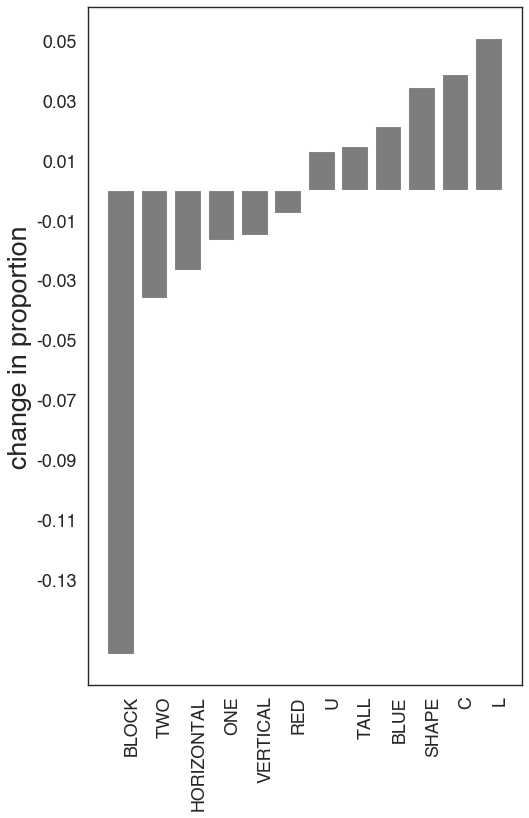

In [25]:
from matplotlib.ticker import FormatStrFormatter

font = {'fontname':'Helvetica'}
sns.set_theme(style='white')

x_limit = 6

labels, values = zip(*rep_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange your data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))

bar_width = 0.35

fig = plt.figure(num=None, figsize=(7, 11), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.bar(indexes, values, color = "#7D7D7D")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# add labels
plt.yticks(fontsize=16, **font)
plt.xticks(indexes + bar_width, labels,  rotation='vertical', fontsize=16, **font)
plt.ylabel("change in proportion", size = 24, **font)
plt.yticks(np.arange(-.13,.06, .02))
ax.axes.get_xaxis().set_visible(True)
#plt.title("highest delta words", size = 24, **font)
plt.show()

## Change in referring expression visualizations

In [26]:
# Exclude a couple of participants that have very different data (which make all other participants appear closer together)

exclude_ids = ['4338-9f5cbb3a-a351-45e4-9b99-dc2737fd4658', #"xxoooxxxo"-type responses
               '9387-db1af5ad-b089-48ad-a730-baee40f08177'  # lots of empty messages
              ]

df_ref_exps = df_ref_exps[~df_ref_exps.dyad_gameid.isin(exclude_ids)].reset_index()

In [28]:
# word count (across all four raters)
df_ref_exps_trial = df_ref_exps.groupby(['dyad_gameid','rep','trial_num'])['BOW_concat'].apply(lambda x: ' '.join(x)).reset_index()
df_ref_exps_trial['word_freq'] = df_ref_exps_trial['BOW_concat'].apply(lambda x: Counter(x.split()))
df_ref_exps_trial

,dyad_gameid,rep,trial_num,BOW_concat,word_freq
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,0.0,TWO BLUE TWO BLUE BLOCK TWO RED TWO RED BLOCK ...,"{'TWO': 12, 'BLUE': 8, 'BLOCK': 14, 'RED': 12,..."
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,1.0,TWO BLUE TWO BLUE BLOCK TWO RED TWO RED BLOCK ...,"{'TWO': 12, 'BLUE': 12, 'BLOCK': 15, 'RED': 8,..."
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,2.0,BLUE TWO RED BLUE BLOCK TWO RED BLUE BLUE BLOC...,"{'BLUE': 13, 'TWO': 4, 'RED': 8, 'BLOCK': 13, ..."
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,3.0,EXACT CONSTRUCTION EXACT CONSTRUCTION ONE RED ...,"{'EXACT': 3, 'CONSTRUCTION': 3, 'ONE': 11, 'RE..."
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,4.0,BLUE TWO RED ONE BLUE BLOCK TWO RED BLOCK BLUE...,"{'BLUE': 12, 'TWO': 12, 'RED': 8, 'ONE': 6, 'B..."
...,...,...,...,...,...
559,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,7.0,BLUE BLUE BLOCK BLUE BLUE ONE TWO RED TWO RED ...,"{'BLUE': 16, 'BLOCK': 6, 'ONE': 2, 'TWO': 8, '..."
560,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,8.0,BLUE BLUE BLOCK TWO RED TWO RED BLUE BLUE RED ...,"{'BLUE': 12, 'BLOCK': 3, 'TWO': 8, 'RED': 8}"
561,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,9.0,BLUE BLUE TWO RED TWO RED BLUE BLUE BLUE ABLUE...,"{'BLUE': 13, 'TWO': 8, 'RED': 8, 'ABLUE': 3}"
562,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,10.0,RED RED TWO BLUE TWO BLUE BLUE BLUE TWO RED ...,"{'RED': 8, 'TWO': 8, 'BLUE': 12}"


In [29]:
# find which words were used by each participant in every trial

df_all_words_trial = df_ref_exps_trial[['dyad_gameid', 'rep', 'trial_num' ,'BOW_concat']]

for w in all_words:
    df_all_words_trial[w] = df_all_words_trial['BOW_concat'].apply(lambda row: int(w in row.split()))

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/3693734041.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words_trial[w] = df_all_words_trial['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/3693734041.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words_trial[w] = df_all_words_trial['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_74721/3693734041.py:6: 

## visualize change across repetition, with TSNE (figure 2B)

In [30]:
# identify some demonstrative examples
ps = [29, 38, 71]

# 29
# ['BLOCK', 'BLUE', 'RED']
# ['BLUE', 'RED']

# 38
# ['BLOCK', 'BLUE', 'L', 'RED', 'TWO']
# ['L', 'U', 'UPSIDE']

# 71
# ['1', 'HORIZONTAL', 'ONE', 'TWO', 'VERTICAL']
# ['L', 'LOWERCASE', 'N', 'SHAPE']

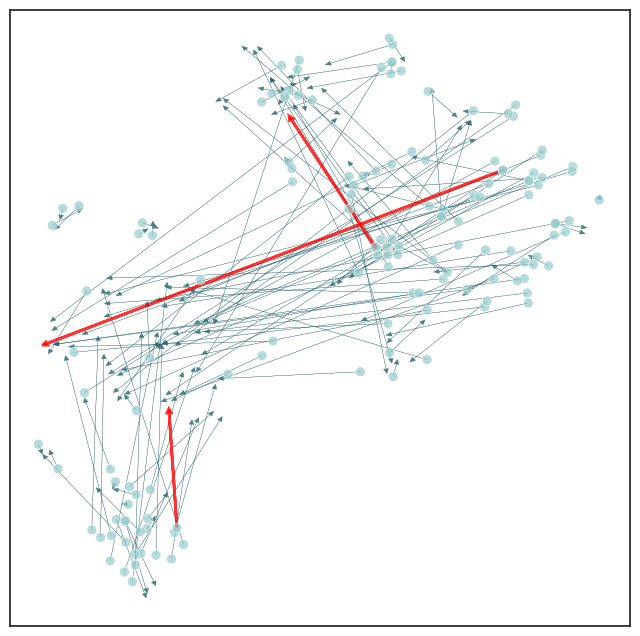

In [31]:
# visualizations using tsne, colored by rep

np.random.seed(0)

both_reps = pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].loc[:,'TWO':'TWR'], df_all_words_trial[(df_all_words_trial.rep == 4)].loc[:,'TWO':'TWR']], axis=0)
rep_labels = list(pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].rep, df_all_words_trial[(df_all_words_trial.rep == 4)].rep]))

pca = PCA(n_components=21)
pca_result = pca.fit_transform(both_reps)

tsne = TSNE(perplexity=15)
X_embedded = tsne.fit_transform(pca_result)
n = int(len(X_embedded[:,0])/2)

sns.set_style('white')

plt.figure(figsize=(8,8))
# palette = list(np.array(sns.color_palette("bright", 2)))
palette = ['#99CCCC']

for i, x in enumerate(X_embedded[:n,0]):
    if not i in ps:
        plt.arrow(x, 
                  X_embedded[i, 1],
                  X_embedded[i+n, 0]-x, 
                  X_embedded[i+n, 1]-X_embedded[i, 1], 
                  shape='full', 
                  lw=0.2, 
                  length_includes_head=True, 
                  overhang=0,
                  color='#21606B', 
                  head_width=0.7,
                  head_length=0.8,
                  alpha=0.8)

for i, x in enumerate(X_embedded[:n,0]):
    if i in ps:
        plt.arrow(x, 
                  X_embedded[i, 1],
                  X_embedded[i+n, 0]-x, 
                  X_embedded[i+n, 1]-X_embedded[i, 1], 
                  shape='full', 
                  lw=2, 
                  length_includes_head=True, 
                  overhang=0,
                  color='#FF0000', 
                  head_width=0.6,
                  head_length=0.7,
                  alpha=0.8)



sns.scatterplot(x = X_embedded[:n,0], 
                y = X_embedded[:n,1], 
                hue=rep_labels[:n], 
                legend=False, 
                palette=palette, 
                alpha=0.7, 
                s=50, 
                linewidth=0.5)

# plt.legend()
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

# plt.savefig('../results/plots/rep1_clusters.pdf')

plt.savefig('../../results/plots/rep4_clusters.pdf')